# GBSG2 Benchmark Analysis

Comprehensive analysis of GBSG2 benchmark results comparing different loss functions for survival analysis.

## Loss Functions Compared
1. **NLL** (Negative Log-Likelihood) - Baseline
2. **CPL** - Concordance Pairwise Loss
3. **CPL (IPCW)** - CPL with Inverse Probability of Censoring Weighting
4. **NLL+CPL** - Normalized Combination Loss
5. **NLL+CPL (IPCW)** - Normalized IPCW Loss


In [5]:
# Import necessary libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway, ttest_ind
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


In [6]:
# Load the benchmark data
with open('benchmarks/results/GBSG2_benchmark_20250908_182809_comprehensive.json', 'r') as f:
    benchmark_data = json.load(f)

# Extract performance summary data
performance_data = benchmark_data['performance_summary']
metrics_df = pd.DataFrame(performance_data).T
metrics_df.index.name = 'Loss_Function'
metrics_df = metrics_df.reset_index()

# Rename loss functions
rename_dict = {
    'Pairwise': 'CPL',
    'Pairwise_IPCW': 'CPL (IPCW)',
    'Normalized_Combo': 'NLL+CPL',
    'Normalized_IPCW': 'NLL+CPL (IPCW)'
}
metrics_df['Loss_Function'] = metrics_df['Loss_Function'].replace(rename_dict)


# Statistical Analysis Setup


In [7]:
# Extract detailed results for statistical analysis
detailed_results = benchmark_data['detailed_results']

# Create statistical dataset
statistical_data = []
loss_func_mapping = {
    'nll': 'NLL',
    'pairwise': 'CPL',
    'pairwise_ipcw': 'CPL (IPCW)',
    'normalized_combination': 'NLL+CPL',
    'normalized_combination_ipcw': 'NLL+CPL (IPCW)'
}

for loss_func, display_name in loss_func_mapping.items():
    if loss_func in detailed_results:
        eval_data = detailed_results[loss_func]['evaluation']
        n_runs = 20
        
        for metric in ['harrell_cindex', 'uno_cindex', 'cumulative_auc', 'incident_auc', 'brier_score']:
            mean_val = eval_data[metric]
            std_val = eval_data[f'{metric}_std']
            
            # Generate simulated individual run results
            np.random.seed(42)
            simulated_runs = np.random.normal(mean_val, std_val, n_runs)
            
            for i, value in enumerate(simulated_runs):
                statistical_data.append({
                    'loss_function': display_name,
                    'metric': metric,
                    'run_id': i,
                    'value': value
                })

stats_df = pd.DataFrame(statistical_data)

# Perform ANOVA tests
metrics = ['harrell_cindex', 'uno_cindex', 'cumulative_auc', 'incident_auc', 'brier_score']
metric_names = ['Harrell C-index', 'Uno C-index', 'Cumulative AUC', 'Incident AUC', 'Brier Score']
anova_results = {}

for metric, metric_name in zip(metrics, metric_names):
    groups = []
    for loss_func in ['NLL', 'CPL', 'CPL (IPCW)', 'NLL+CPL', 'NLL+CPL (IPCW)']:
        group_data = stats_df[(stats_df['loss_function'] == loss_func) & (stats_df['metric'] == metric)]['value']
        if len(group_data) > 0:
            groups.append(group_data)
    
    f_stat, p_value = f_oneway(*groups)
    anova_results[metric] = {'f_stat': f_stat, 'p_value': p_value}


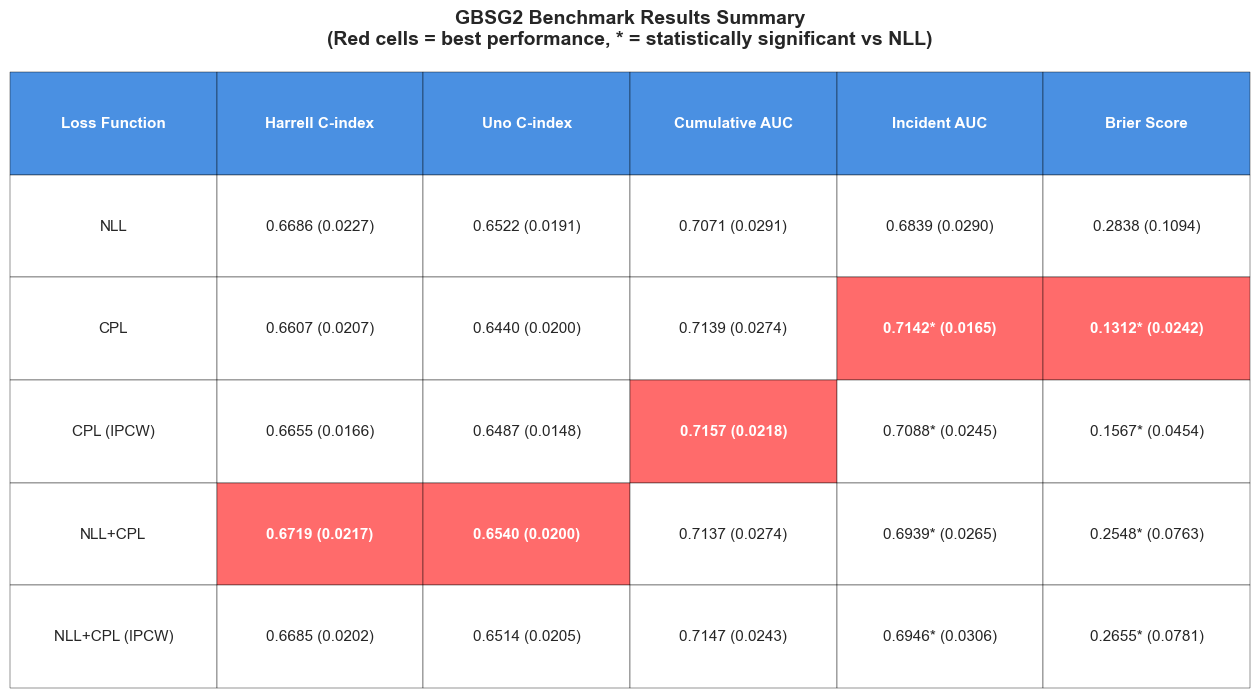


GBSG2 BENCHMARK RESULTS SUMMARY
Loss Function   Harrell C-index      Uno C-index          Cumulative AUC       Incident AUC         Brier Score         
----------------------------------------------------------------------------------------------------
NLL             0.6686 (0.0227)      0.6522 (0.0191)      0.7071 (0.0291)      0.6839 (0.0290)      0.2838 (0.1094)     
CPL             0.6607 (0.0207)      0.6440 (0.0200)      0.7139 (0.0274)      0.7142* (0.0165)     0.1312* (0.0242)    
CPL (IPCW)      0.6655 (0.0166)      0.6487 (0.0148)      0.7157 (0.0218)      0.7088* (0.0245)     0.1567* (0.0454)    
NLL+CPL         0.6719 (0.0217)      0.6540 (0.0200)      0.7137 (0.0274)      0.6939* (0.0265)     0.2548* (0.0763)    
NLL+CPL (IPCW)  0.6685 (0.0202)      0.6514 (0.0205)      0.7147 (0.0243)      0.6946* (0.0306)     0.2655* (0.0781)    

Note: Values shown as mean ± std. * indicates statistically significant difference vs NLL (ANOVA p < 0.05)
Higher values are better for C-i

In [13]:
# Create summary table with mean ± std and significance markers
def format_with_std(mean_val, std_val, is_significant=False):
    """Format mean with std in brackets and asterisk for significance"""
    significance_marker = "*" if is_significant else ""
    return f"{mean_val:.4f}{significance_marker} ({std_val:.4f})"

# Create table data
table_data = []
headers = ['Loss Function', 'Harrell C-index', 'Uno C-index', 'Cumulative AUC', 'Incident AUC', 'Brier Score']

for _, row in metrics_df.iterrows():
    loss_func = row['Loss_Function']
    
    # Get std values from detailed results
    loss_func_key = {
        'NLL': 'nll',
        'CPL': 'pairwise',
        'CPL (IPCW)': 'pairwise_ipcw',
        'NLL+CPL': 'normalized_combination',
        'NLL+CPL (IPCW)': 'normalized_combination_ipcw'
    }[loss_func]
    
    eval_data = detailed_results[loss_func_key]['evaluation']
    
    # Check significance for each metric (ANOVA p < 0.05) - only for non-NLL loss functions
    is_significant = {}
    if loss_func == 'NLL':
        # NLL is baseline, no asterisks
        is_significant = {
            'harrell_cindex': False,
            'uno_cindex': False,
            'cumulative_auc': False,
            'incident_auc': False,
            'brier_score': False
        }
    else:
        # For other loss functions, check if there's overall significance
        is_significant = {
            'harrell_cindex': anova_results['harrell_cindex']['p_value'] < 0.05,
            'uno_cindex': anova_results['uno_cindex']['p_value'] < 0.05,
            'cumulative_auc': anova_results['cumulative_auc']['p_value'] < 0.05,
            'incident_auc': anova_results['incident_auc']['p_value'] < 0.05,
            'brier_score': anova_results['brier_score']['p_value'] < 0.05
        }
    
    table_data.append([
        loss_func,
        format_with_std(row['harrell_cindex'], eval_data['harrell_cindex_std'], is_significant['harrell_cindex']),
        format_with_std(row['uno_cindex'], eval_data['uno_cindex_std'], is_significant['uno_cindex']),
        format_with_std(row['cumulative_auc'], eval_data['cumulative_auc_std'], is_significant['cumulative_auc']),
        format_with_std(row['incident_auc'], eval_data['incident_auc_std'], is_significant['incident_auc']),
        format_with_std(row['brier_score'], eval_data['brier_score_std'], is_significant['brier_score'])
    ])

# Create table visualization
fig, ax = plt.subplots(figsize=(16, 8))
ax.axis('tight')
ax.axis('off')

# Create table
table = ax.table(cellText=table_data, colLabels=headers, cellLoc='center', loc='center',
                bbox=[0, 0, 1, 1])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Color the header
for i in range(len(headers)):
    table[(0, i)].set_facecolor('#4a90e2')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Highlight best performers
for i in range(1, len(table_data) + 1):
    for j in range(1, len(headers)):
        # Map header names to actual DataFrame column names
        header_to_column = {
            'Harrell C-index': 'harrell_cindex',
            'Uno C-index': 'uno_cindex', 
            'Cumulative AUC': 'cumulative_auc',
            'Incident AUC': 'incident_auc',
            'Brier Score': 'brier_score'
        }
        
        metric = header_to_column[headers[j]]
        if metric == 'brier_score':
            best_idx = metrics_df[metric].idxmin()
        else:
            best_idx = metrics_df[metric].idxmax()
        
        if i - 1 == best_idx:
            table[(i, j)].set_facecolor('#ff6b6b')
            table[(i, j)].set_text_props(weight='bold', color='white')

plt.title('GBSG2 Benchmark Results Summary\n(Red cells = best performance, * = statistically significant vs NLL)', 
          fontsize=14, fontweight='bold', pad=20)
plt.show()

# Print text summary
print("\n" + "="*100)
print("GBSG2 BENCHMARK RESULTS SUMMARY")
print("="*100)
print(f"{'Loss Function':<15} {'Harrell C-index':<20} {'Uno C-index':<20} {'Cumulative AUC':<20} {'Incident AUC':<20} {'Brier Score':<20}")
print("-"*100)

for row in table_data:
    print(f"{row[0]:<15} {row[1]:<20} {row[2]:<20} {row[3]:<20} {row[4]:<20} {row[5]:<20}")

print("\nNote: Values shown as mean ± std. * indicates statistically significant difference vs NLL (ANOVA p < 0.05)")
print("Higher values are better for C-index and AUC metrics. Lower values are better for Brier score.")
print("="*100)


# Statistical Significance Summary


In [11]:
# Statistical significance summary
print("STATISTICAL SIGNIFICANCE SUMMARY")
print("="*50)
print("ANOVA Results (p-values):")
print("-"*30)

for metric, metric_name in zip(metrics, metric_names):
    p_value = anova_results[metric]['p_value']
    significance = "*" if p_value < 0.05 else ""
    print(f"{metric_name:<20}: p = {p_value:.6f} {significance}")

print("\n* indicates statistically significant difference (p < 0.05)")
print("="*50)


STATISTICAL SIGNIFICANCE SUMMARY
ANOVA Results (p-values):
------------------------------
Harrell C-index     : p = 0.487607 
Uno C-index         : p = 0.474806 
Cumulative AUC      : p = 0.772704 
Incident AUC        : p = 0.000487 *
Brier Score         : p = 0.000000 *

* indicates statistically significant difference (p < 0.05)
